# **CV PROJECT: Bone Tumor X-Ray Detection & Classification**

## **MODEL BUILDING:**
### **DENSENET121 & 201 and EFFICIENTB4**
Author : Karthik Paranthaman


---
**IMPORT LIBRARIES:**

In [ ]:
# System and OS utilities
import os
import math
import time
import random
import shutil
import json
import pickle

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Image handling
from PIL import Image, ImageEnhance
import cv2

# Deep Learning - TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB2, EfficientNetB4, DenseNet121
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Scikit-learn utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# Miscellaneous
from collections import Counter

# Pandas display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


**PATH DEFINITIONS:**

In [2]:
# Path setup
BASE_DIR = r"F:\NW_MSDS\Term-6\CV\Project\Bone_xray\BTXRD"
IMG_DIR = os.path.join(BASE_DIR,"BTXRD", "images")
ANNOTATION_DIR = os.path.join(BASE_DIR,"BTXRD", "Annotations")
EXCEL_PATH = os.path.join(BASE_DIR, "BTXRD", "dataset.xlsx")

**LOAD METADATA:**

In [3]:
df = pd.read_excel(EXCEL_PATH)
df.head()

,image_id,center,age,gender,hand,ulna,radius,humerus,foot,tibia,fibula,femur,hip bone,ankle-joint,knee-joint,hip-joint,wrist-joint,elbow-joint,shoulder-joint,tumor,benign,malignant,osteochondroma,multiple osteochondromas,simple bone cyst,giant cell tumor,osteofibroma,synovial osteochondroma,other bt,osteosarcoma,other mt,upper limb,lower limb,pelvis,frontal,lateral,oblique
0,IMG000001.jpeg,1,48,F,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0
1,IMG000002.jpeg,1,12,M,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0
2,IMG000003.jpeg,1,12,M,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0
3,IMG000004.jpeg,1,52,M,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0
4,IMG000005.jpeg,1,52,M,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1


In [4]:
df.shape

(3746, 37)

**TARGET LABEL CREATION:**

In [7]:
# Create target label
def get_label(row):
    if row['tumor'] == 0:
        return 'Normal'
    elif row['benign'] == 1:
        return 'Benign'
    elif row['malignant'] == 1:
        return 'Malignant'
    return 'Unknown'

df['label'] = df.apply(get_label, axis=1)

# Image path column
df['image_path'] = df['image_id'].apply(lambda x: os.path.join(IMG_DIR,x))
df['image_exists'] = df['image_path'].apply(os.path.exists)


**SAMPLE X-RAY VIEWER:**

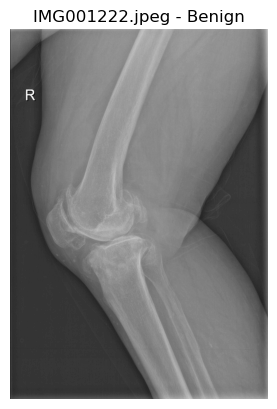

In [10]:
def show_xray(idx):
    row = df.iloc[idx]
    img = cv2.imread(row['image_path'], cv2.IMREAD_GRAYSCALE)
    if img is not None:
        plt.imshow(img, cmap='gray')
        plt.title(f"{row['image_id']} - {row['label']}")
        plt.axis('off')
        plt.show()
    else:
        print("Image not found.")

# Random sample
show_xray(df[df['label'] != 'Unknown'].sample(969).index[0])


**PARSE ANNOTATIONS:**

In [11]:
def load_annotation(image_id):
    json_path = os.path.join(ANNOTATION_DIR, f"{image_id}.json")
    if os.path.exists(json_path):
        with open(json_path, 'r') as f:
            return json.load(f)
    return None


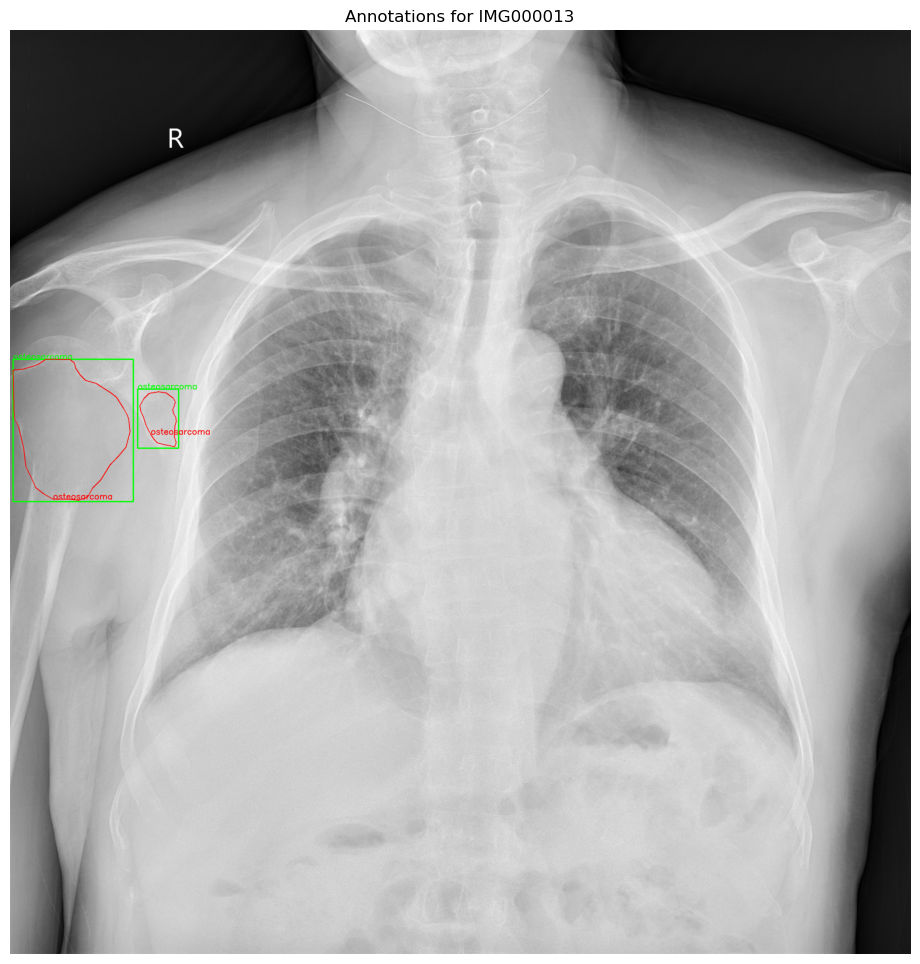

In [12]:
def draw_annotation(image_id):
    ann = load_annotation(image_id)
    if not ann:
        print(f"No annotation found for {image_id}")
        return

    img_path = os.path.join(IMG_DIR, ann['imagePath'])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for shape in ann['shapes']:
        label = shape['label']
        pts = shape['points']
        if shape['shape_type'] == 'rectangle':
            pt1, pt2 = tuple(map(int, pts[0])), tuple(map(int, pts[1]))
            cv2.rectangle(img, pt1, pt2, (0,255,0), 3)
            cv2.putText(img, label, pt1, cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
        elif shape['shape_type'] == 'polygon':
            polygon = np.array(pts, np.int32).reshape((-1, 1, 2))
            cv2.polylines(img, [polygon], isClosed=True, color=(255,0,0), thickness=2)
            cv2.putText(img, label, tuple(map(int, pts[0])), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2)

    plt.figure(figsize=(12, 12))
    plt.imshow(img)
    plt.title(f"Annotations for {image_id}")
    plt.axis('off')
    plt.show()

#draw_annotation('IMG000529')
draw_annotation('IMG000013')


---
### **MODEL TRAINING:**

In [13]:

def evaluate_model(model, data, dataset_name="Test"):
    """Generate classification report and confusion matrix for given dataset."""
    preds = model.predict(data)
    y_pred = np.argmax(preds, axis=1)
    y_true = data.classes
    labels = list(data.class_indices.keys())
    
    print(f"\n Classification Report ({dataset_name})")
    print(classification_report(y_true, y_pred, target_names=labels))
    
    plot_confusion_matrix(y_true, y_pred, labels, title=f"Confusion Matrix - {dataset_name}")

def plot_confusion_matrix(y_true, y_pred, labels, title="Confusion Matrix"):
    """Plot confusion matrix as a heatmap."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def plot_training_curves(history, title_prefix=""):
    """Plot accuracy and loss curves for training history."""
    plt.figure(figsize=(12,5))
    
    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title(f'{title_prefix} Accuracy vs Epochs')
    
    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title(f'{title_prefix} Loss vs Epochs')
    
    plt.show()


In [15]:
df_model = df[(df['label'].isin(['Malignant','Normal','Benign'])) & df['image_exists']]
df_model.head()

,image_id,center,age,gender,hand,ulna,radius,humerus,foot,tibia,fibula,femur,hip bone,ankle-joint,knee-joint,hip-joint,wrist-joint,elbow-joint,shoulder-joint,tumor,benign,malignant,osteochondroma,multiple osteochondromas,simple bone cyst,giant cell tumor,osteofibroma,synovial osteochondroma,other bt,osteosarcoma,other mt,upper limb,lower limb,pelvis,frontal,lateral,oblique,label,image_path,image_exists
0,IMG000001.jpeg,1,48,F,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,Malignant,F:\NW_MSDS\Term-6\CV\Project\Bone_xray\BTXRD\B...,True
1,IMG000002.jpeg,1,12,M,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,Malignant,F:\NW_MSDS\Term-6\CV\Project\Bone_xray\BTXRD\B...,True
2,IMG000003.jpeg,1,12,M,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,Malignant,F:\NW_MSDS\Term-6\CV\Project\Bone_xray\BTXRD\B...,True
3,IMG000004.jpeg,1,52,M,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,Malignant,F:\NW_MSDS\Term-6\CV\Project\Bone_xray\BTXRD\B...,True
4,IMG000005.jpeg,1,52,M,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,Malignant,F:\NW_MSDS\Term-6\CV\Project\Bone_xray\BTXRD\B...,True


**TRAIN, VALIDATION & TEST SPLIT:**

In [16]:
train_df, test_df = train_test_split(df_model, stratify = df_model['label'], test_size=0.2,random_state=369)
train_df, val_df = train_test_split(train_df,stratify = train_df['label'], test_size=0.2, random_state=369)

# Train, Validation & Test Split size:
print(f"Train Dataset Size : {train_df.shape}")
print(f"Validation Dataset Size : {val_df.shape}")
print(f"Test Dataset Size : {test_df.shape}")

Train Dataset Size : (2396, 40)
Validation Dataset Size : (600, 40)
Test Dataset Size : (750, 40)


In [17]:
test_df['label'].value_counts()

label
Normal       376
Benign       305
Malignant     69
Name: count, dtype: int64

**IMage Augmentation:**

In [18]:
AUG_DIR = os.path.join(BASE_DIR,"augmented_malignant")
os.makedirs(AUG_DIR,exist_ok=True)

def strong_augment_pil(img: Image.Image):
    """Stronger, but label-safe transforms: rotate, flip, zoom (crop & resize), brightness/contrast."""
    # Random rotate
    angle = random.choice([0, 90, 180, 270]) if random.random() < 0.4 else random.uniform(-20, 20)
    img = img.rotate(angle)

    # Horizontal flip
    if random.random() < 0.5:
        img = img.transpose(Image.FLIP_LEFT_RIGHT)

    # Random zoom via center crop
    if random.random() < 0.6:
        w, h = img.size
        zoom = random.uniform(0.85, 1.0)   
        new_w, new_h = int(w*zoom), int(h*zoom)
        left = (w - new_w) // 2
        top  = (h - new_h) // 2
        img = img.crop((left, top, left+new_w, top+new_h))
        img = img.resize((w, h), Image.BICUBIC)

    # Brightness & contrast
    if random.random() < 0.8:
        img = ImageEnhance.Brightness(img).enhance(random.uniform(0.8, 1.2))
    if random.random() < 0.8:
        img = ImageEnhance.Contrast(img).enhance(random.uniform(0.8, 1.3))

    return img


def augment_malignant_to_target(train_df, target_per_class=None, copies_per_image=None, img_size=(224,224)):
   
    malignant_df = train_df[train_df['label'] == 'Malignant'].copy()
    benign_df    = train_df[train_df['label'] == 'Benign'].copy()
    normal_df    = train_df[train_df['label'] == 'Normal'].copy()

    counts = {
        'Normal': len(normal_df),
        'Benign': len(benign_df),
        'Malignant': len(malignant_df)
    }
    print("Pre-augmentation:", counts)

    if target_per_class is None and copies_per_image is None:
        
        target_per_class = max(counts['Normal'], counts['Benign'])

   
    if target_per_class is not None:
        need = max(0, target_per_class - counts['Malignant'])
    else:
        need = len(malignant_df) * copies_per_image

    if need == 0:
        print("No malignant augmentation needed.")
        return train_df

   
    aug_rows = []
    malignant_paths = malignant_df['image_path'].tolist()
    labels = malignant_df['label'].tolist()
    n = len(malignant_paths)

    
    created = 0
    idx = 0
    while created < need:
        src_path = malignant_paths[idx % n]
        src_label = labels[idx % n]
        try:
            with Image.open(src_path) as img:
                
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                img = img.resize(img_size, Image.BICUBIC)
                img_aug = strong_augment_pil(img)

               
                base = os.path.splitext(os.path.basename(src_path))[0]
                out_name = f"{base}_AUG_{created:05d}.jpg"
                out_path = os.path.join(AUG_DIR, out_name)
                img_aug.save(out_path, quality=95)

                aug_rows.append({'image_path': out_path, 'label': src_label})
                created += 1
        except Exception as e:
            print(f"Aug error: {src_path} -> {e}")
        idx += 1

    aug_df = pd.DataFrame(aug_rows)
    train_df_aug = pd.concat([train_df[['image_path','label']], aug_df], ignore_index=True)
    print("Post-augmentation counts:\n", train_df_aug['label'].value_counts())
    return train_df_aug


max_train_class = train_df['label'].value_counts().max()
train_df_aug = augment_malignant_to_target(train_df, target_per_class=max_train_class, img_size=(224,224))


Pre-augmentation: {'Normal': 1202, 'Benign': 976, 'Malignant': 218}
Post-augmentation counts:
 label
Normal       1202
Malignant    1202
Benign        976
Name: count, dtype: int64


**IMAGE GNENERATORS:**

In [19]:
IMG_SIZE = 224
BATCH_SIZE = 32

train_gen = ImageDataGenerator(rescale = 1./255,
                               rotation_range = 20,
                               width_shift_range=0.15,
                               height_shift_range = 0.15,
                               zoom_range = 0.2,
                               horizontal_flip = True,
                               fill_mode = 'nearest')

val_test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_dataframe(train_df_aug,
                                           x_col='image_path',
                                           y_col='label',
                                           target_size=(IMG_SIZE,IMG_SIZE),
                                           class_mode = 'categorical',
                                           batch_size=BATCH_SIZE,
                                           shuffle = True,
                                           seed = 369)

val_data = val_test_gen.flow_from_dataframe(val_df,
                                            x_col = 'image_path',
                                            y_col='label',
                                            target_size = (IMG_SIZE,IMG_SIZE),
                                            class_mode= 'categorical',
                                            batch_size = BATCH_SIZE,
                                            shuffle = False)

test_data = val_test_gen.flow_from_dataframe(test_df,
                                             x_col = 'image_path',
                                             y_col = 'label',
                                             target_size = (IMG_SIZE,IMG_SIZE),
                                             class_mode = 'categorical',
                                             batch_size = BATCH_SIZE,
                                             shuffle = False)



Found 3380 validated image filenames belonging to 3 classes.
Found 600 validated image filenames belonging to 3 classes.
Found 750 validated image filenames belonging to 3 classes.


**CLASS WEIGHTS:**

In [20]:
class_indices = train_data.class_indices 
class_indices

{'Benign': 0, 'Malignant': 1, 'Normal': 2}

In [21]:
inv_class_indices = {v:k for k,v in class_indices.items()}


y_train_int = train_data.classes  
classes_sorted = np.unique(y_train_int)

cw = compute_class_weight(class_weight='balanced', classes=classes_sorted, y=y_train_int)
class_weight = {int(c): float(w) for c, w in zip(classes_sorted, cw)}
print("Class indices:", class_indices)
print("Class weights:", {inv_class_indices[k]: v for k,v in class_weight.items()})

Class indices: {'Benign': 0, 'Malignant': 1, 'Normal': 2}
Class weights: {'Benign': 1.1543715846994536, 'Malignant': 0.93732667775929, 'Normal': 0.93732667775929}


In [22]:
class_weight = {
    0: 1.0,   # Benign
    1: 1.5,   # Malignant
    2: 0.75    # Normal 
}


---
**Build & Train DENSENET121 Model:**

In [ ]:
base_model = DenseNet121(weights = 'imagenet',
                            include_top = False,
                            input_shape=(IMG_SIZE,IMG_SIZE,3))

# Freezing base layers:
base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256,activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(len(train_data.class_indices), activation = 'softmax')(x)

model = Model(inputs = base_model.input, outputs = output)
model.compile(optimizer = Adam(learning_rate=1e-4),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
    ModelCheckpoint(filepath=os.path.join(BASE_DIR, 'denseNet_best.keras'),
                    monitor='val_loss', save_best_only=True, verbose=1)
]


start = time.time()
history = model.fit(train_data, 
                    validation_data = val_data,
                    epochs = 30,
                    class_weight = class_weight,
                    callbacks = callbacks,
                    verbose=1)
end = time.time()
print(f"Training Time : {round((end-start),2)}")

e:\Anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3714 - loss: 1.2963
Epoch 1: val_loss improved from inf to 0.97612, saving model to F:\NW_MSDS\Term-6\CV\Project\Bone_xray\BTXRD\denseNet_best.keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 206s 2s/step - accuracy: 0.3718 - loss: 1.2952 - val_accuracy: 0.5083 - val_loss: 0.9761 - learning_rate: 1.0000e-04
Epoch 2/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5259 - loss: 0.9847
Epoch 2: val_loss improved from 0.97612 to 0.90836, saving model to F:\NW_MSDS\Term-6\CV\Project\Bone_xray\BTXRD\denseNet_best.keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - accuracy: 0.5261 - loss: 0.9845 - val_accuracy: 0.5867 - val_loss: 0.9084 - learning_rate: 1.0000e-04
Epoch 3/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5868 - loss: 0.8943
Epoch 3: val_loss improved from 0.90836 to 0.85838, saving model to F:\NW_MSDS\Term-6\CV\Project\Bone_xray\BTXRD\denseNet_best.keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 189s 2s/step - accuracy: 0.58

**Model Evaluation:**

Found 3380 validated image filenames belonging to 3 classes.


e:\Anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


106/106 ━━━━━━━━━━━━━━━━━━━━ 175s 2s/step

 Classification Report (Train)
              precision    recall  f1-score   support

      Benign       0.71      0.67      0.69       976
   Malignant       0.85      0.89      0.87      1202
      Normal       0.77      0.77      0.77      1202

    accuracy                           0.78      3380
   macro avg       0.78      0.78      0.78      3380
weighted avg       0.78      0.78      0.78      3380



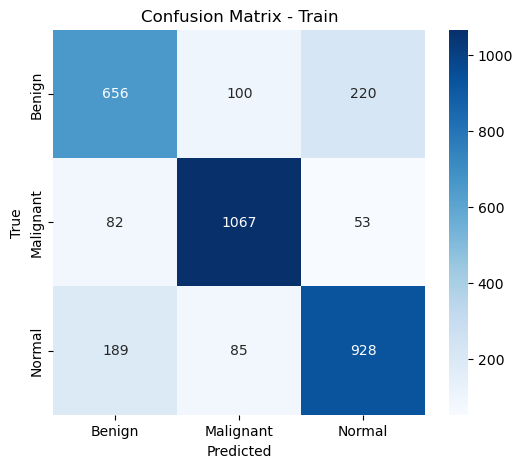

e:\Anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step

 Classification Report (Validation)
              precision    recall  f1-score   support

      Benign       0.67      0.61      0.64       244
   Malignant       0.52      0.27      0.36        55
      Normal       0.70      0.81      0.75       301

    accuracy                           0.68       600
   macro avg       0.63      0.56      0.58       600
weighted avg       0.67      0.68      0.67       600



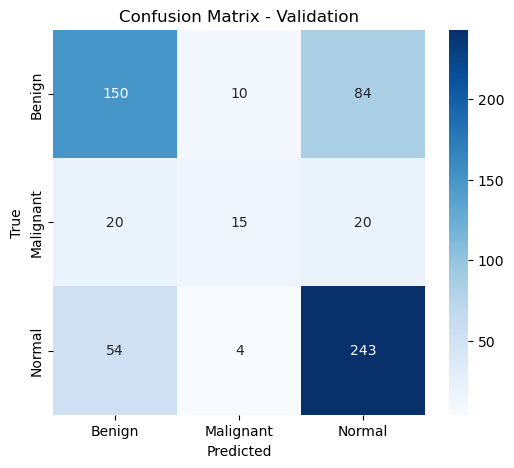

e:\Anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step

 Classification Report (Test)
              precision    recall  f1-score   support

      Benign       0.65      0.60      0.63       305
   Malignant       0.62      0.23      0.34        69
      Normal       0.70      0.82      0.76       376

    accuracy                           0.68       750
   macro avg       0.66      0.55      0.57       750
weighted avg       0.67      0.68      0.67       750



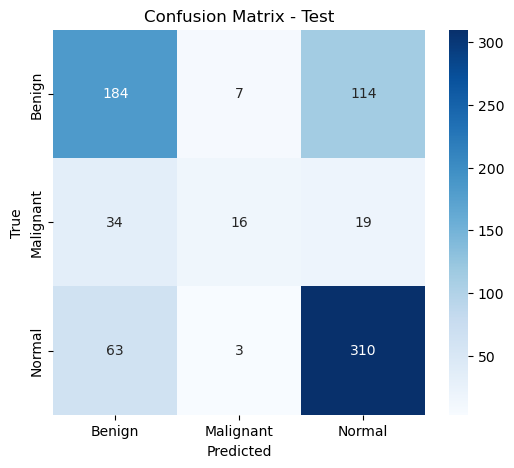

In [23]:
train_data_eval = train_gen.flow_from_dataframe(
    train_df_aug,
    x_col='image_path',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False, 
    seed=369
)

best_model_path = os.path.join(BASE_DIR,"denseNet_best.keras")
best_model = load_model(best_model_path)

evaluate_model(best_model, train_data_eval, dataset_name="Train")
evaluate_model(best_model, val_data, dataset_name="Validation")
evaluate_model(best_model, test_data, dataset_name="Test")

#plot_training_curves(history, title_prefix="DenseNet121")

In [ ]:
model = load_model(os.path.join(BASE_DIR, 'denseNet_best.keras'))
trainable_count = 0
for layer in reversed(model.layers):
    if trainable_count < 30 and not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True
        trainable_count += 1
    else:
        layer.trainable = False

print("Trainable layers:")
for layer in model.layers:
    if layer.trainable:
        print(f"{layer.name} ({layer.__class__.__name__})")

Trainable layers:
conv5_block12_0_relu (Activation)
conv5_block12_1_conv (Conv2D)
conv5_block12_1_relu (Activation)
conv5_block12_2_conv (Conv2D)
conv5_block12_concat (Concatenate)
conv5_block13_0_relu (Activation)
conv5_block13_1_conv (Conv2D)
conv5_block13_1_relu (Activation)
conv5_block13_2_conv (Conv2D)
conv5_block13_concat (Concatenate)
conv5_block14_0_relu (Activation)
conv5_block14_1_conv (Conv2D)
conv5_block14_1_relu (Activation)
conv5_block14_2_conv (Conv2D)
conv5_block14_concat (Concatenate)
conv5_block15_0_relu (Activation)
conv5_block15_1_conv (Conv2D)
conv5_block15_1_relu (Activation)
conv5_block15_2_conv (Conv2D)
conv5_block15_concat (Concatenate)
conv5_block16_0_relu (Activation)
conv5_block16_1_conv (Conv2D)
conv5_block16_1_relu (Activation)
conv5_block16_2_conv (Conv2D)
conv5_block16_concat (Concatenate)
relu (Activation)
global_average_pooling2d (GlobalAveragePooling2D)
dense (Dense)
dropout (Dropout)
dense_1 (Dense)


In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
    ModelCheckpoint(filepath=os.path.join(BASE_DIR, 'denseNet_best_fineTuned.keras'),
                    monitor='val_loss', save_best_only=True, verbose=1)
]

start = time.time()
history_finetune = model.fit(train_data,
                             validation_data=val_data,
                             epochs=30,
                             class_weight=class_weight,
                             callbacks=callbacks,
                             verbose=1)
end = time.time()
print(f"Fine-tuning Time : {round((end - start), 2)} seconds")

Epoch 1/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7627 - loss: 0.5779
Epoch 1: val_loss improved from inf to 0.71228, saving model to F:\NW_MSDS\Term-6\CV\Project\Bone_xray\BTXRD\denseNet_best_fineTuned.keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - accuracy: 0.7628 - loss: 0.5779 - val_accuracy: 0.6917 - val_loss: 0.7123 - learning_rate: 1.0000e-05
Epoch 2/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7596 - loss: 0.5900
Epoch 2: val_loss did not improve from 0.71228
106/106 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - accuracy: 0.7596 - loss: 0.5899 - val_accuracy: 0.6767 - val_loss: 0.7123 - learning_rate: 1.0000e-05
Epoch 3/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7767 - loss: 0.5518
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 3: val_loss did not improve from 0.71228
106/106 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - accuracy: 0.7767 - loss: 0.5519 - val_accuracy: 0.7000 - val_loss: 0.7283 - learning_rate: 1.0000e-

106/106 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step

 Classification Report (Train)
              precision    recall  f1-score   support

      Benign       0.68      0.71      0.69       976
   Malignant       0.86      0.86      0.86      1202
      Normal       0.78      0.75      0.76      1202

    accuracy                           0.78      3380
   macro avg       0.77      0.77      0.77      3380
weighted avg       0.78      0.78      0.78      3380



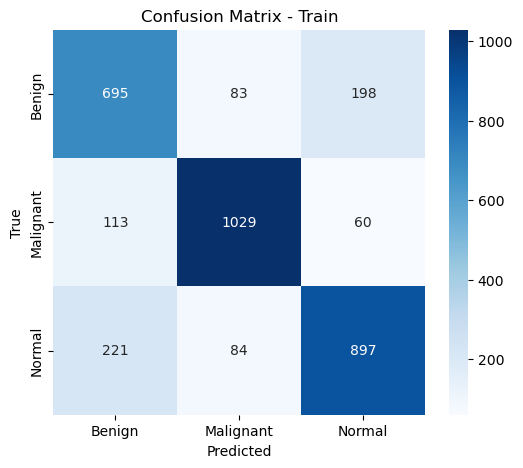

19/19 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step

 Classification Report (Validation)
              precision    recall  f1-score   support

      Benign       0.67      0.65      0.66       244
   Malignant       0.48      0.25      0.33        55
      Normal       0.72      0.81      0.76       301

    accuracy                           0.69       600
   macro avg       0.63      0.57      0.59       600
weighted avg       0.68      0.69      0.68       600



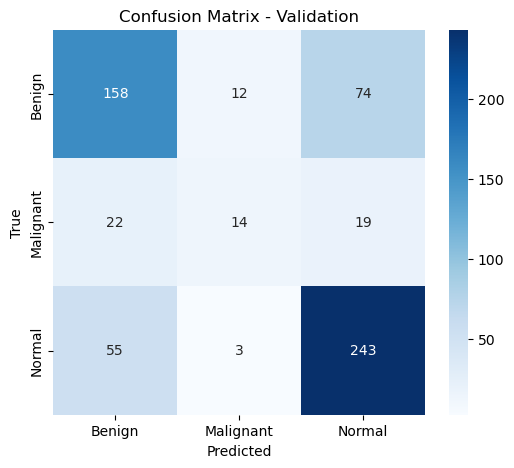

24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step

 Classification Report (Test)
              precision    recall  f1-score   support

      Benign       0.66      0.63      0.64       305
   Malignant       0.62      0.23      0.34        69
      Normal       0.71      0.81      0.76       376

    accuracy                           0.69       750
   macro avg       0.66      0.56      0.58       750
weighted avg       0.68      0.69      0.67       750



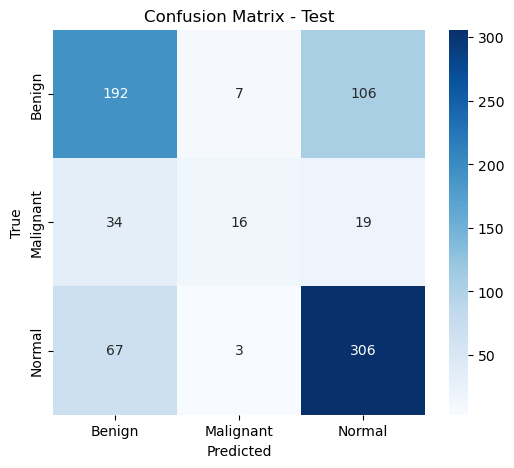

In [24]:

best_model_path = os.path.join(BASE_DIR,"denseNet_best_fineTuned.keras")
best_model = load_model(best_model_path)

evaluate_model(best_model, train_data_eval, dataset_name="Train")
evaluate_model(best_model, val_data, dataset_name="Validation")
evaluate_model(best_model, test_data, dataset_name="Test")

#plot_training_curves(history_finetune, title_prefix="DenseNet121_FineTuned")

---
### **DENSENET201:**

**DenseNet 201 Frozen Training:**

In [ ]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import os
import time
import pickle

# Load DenseNet201 base model
densenet201_base = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
densenet201_base.trainable = False  

# Custom classification head
x = GlobalAveragePooling2D()(densenet201_base.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
densenet201_output = Dense(len(train_data.class_indices), activation='softmax')(x)

# Full model
densenet201_frozen_model = Model(inputs=densenet201_base.input, outputs=densenet201_output)

# Compile model
densenet201_frozen_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
densenet201_callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
    ModelCheckpoint(
        filepath=os.path.join(BASE_DIR, 'densenet201_FROZEN.keras'),
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

# Train
start = time.time()
history_frozen_201 = densenet201_frozen_model.fit(
    train_data,
    validation_data=val_data,
    epochs=30,
    class_weight=class_weight,
    callbacks=densenet201_callbacks,
    verbose=1
)
end = time.time()
print(f"DenseNet201 fully frozen Training Time: {round(end - start, 2)} seconds")

# Save training history
with open(os.path.join(BASE_DIR, 'history_frozen_201.pkl'), 'wb') as f:
    pickle.dump(history_frozen_201.history, f)


Epoch 1/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4094 - loss: 1.2385
Epoch 1: val_loss improved from inf to 1.03765, saving model to F:\NW_MSDS\Term-6\CV\Project\Bone_xray\BTXRD\densenet201_FROZEN.keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 249s 2s/step - accuracy: 0.4098 - loss: 1.2374 - val_accuracy: 0.4683 - val_loss: 1.0376 - learning_rate: 1.0000e-04
Epoch 2/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5507 - loss: 0.9568
Epoch 2: val_loss improved from 1.03765 to 0.98874, saving model to F:\NW_MSDS\Term-6\CV\Project\Bone_xray\BTXRD\densenet201_FROZEN.keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 241s 2s/step - accuracy: 0.5508 - loss: 0.9566 - val_accuracy: 0.5100 - val_loss: 0.9887 - learning_rate: 1.0000e-04
Epoch 3/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6072 - loss: 0.8467
Epoch 3: val_loss improved from 0.98874 to 0.90703, saving model to F:\NW_MSDS\Term-6\CV\Project\Bone_xray\BTXRD\densenet201_FROZEN.keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 238s 2s/step -

**DenseNet 201 Frozen Evaluation:**

Found 3380 validated image filenames belonging to 3 classes.


e:\Anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


106/106 ━━━━━━━━━━━━━━━━━━━━ 218s 2s/step

 Classification Report (Train)
              precision    recall  f1-score   support

      Benign       0.73      0.64      0.68       976
   Malignant       0.77      0.95      0.85      1202
      Normal       0.80      0.70      0.75      1202

    accuracy                           0.77      3380
   macro avg       0.77      0.76      0.76      3380
weighted avg       0.77      0.77      0.77      3380



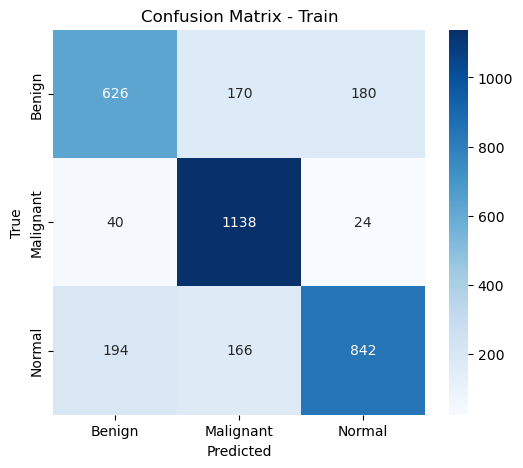

19/19 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step

 Classification Report (Validation)
              precision    recall  f1-score   support

      Benign       0.69      0.62      0.65       244
   Malignant       0.46      0.33      0.38        55
      Normal       0.71      0.80      0.75       301

    accuracy                           0.69       600
   macro avg       0.62      0.58      0.60       600
weighted avg       0.68      0.69      0.68       600



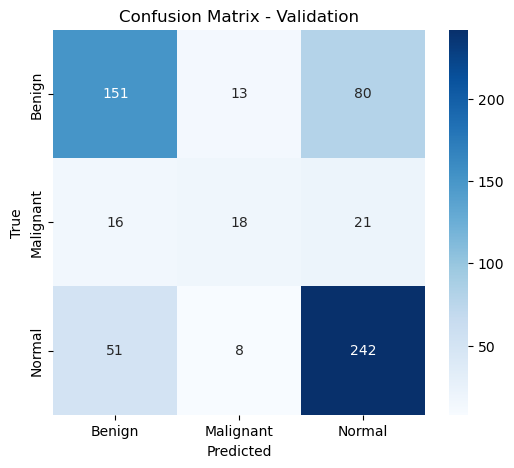

24/24 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step

 Classification Report (Test)
              precision    recall  f1-score   support

      Benign       0.67      0.60      0.63       305
   Malignant       0.35      0.28      0.31        69
      Normal       0.72      0.81      0.76       376

    accuracy                           0.67       750
   macro avg       0.58      0.56      0.57       750
weighted avg       0.66      0.67      0.67       750



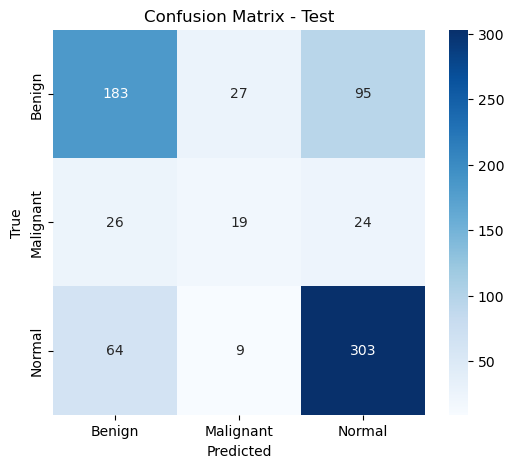

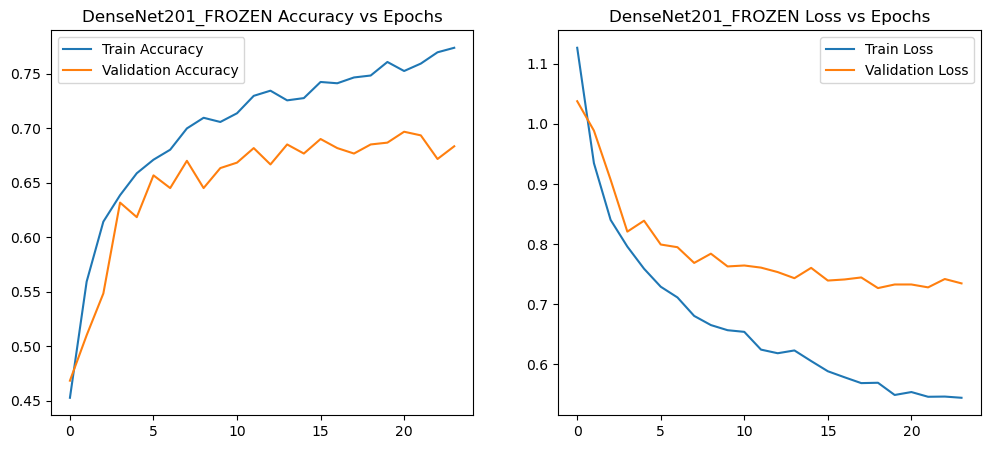


--- Inference Durations ---
Training data:   219.99 seconds
Validation data: 43.3 seconds
Test data:       47.56 seconds


In [29]:
from tensorflow.keras.models import load_model
import time
import os

# Evaluation data generator (shuffle must be False for consistent results)
train_data_eval_201 = train_gen.flow_from_dataframe(
    train_df_aug,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

# Load the best saved frozen DenseNet201 model
densenet201_frozen_best_path = os.path.join(BASE_DIR, 'densenet201_FROZEN.keras')
densenet201_frozen_best_model = load_model(densenet201_frozen_best_path)


# Load DenseNet201 model training history:
history_path = os.path.join(BASE_DIR, 'history_frozen_201.pkl')
with open(history_path, 'rb') as f:
    history_frozen_201_dict = pickle.load(f)

class DummyHistory:
    def __init__(self, history_dict):
        self.history = history_dict
history_frozen_201 = DummyHistory(history_frozen_201_dict)


# Evaluate on Train set
train_start = time.time()
evaluate_model(densenet201_frozen_best_model, train_data_eval_201, dataset_name="Train")
train_end = time.time()

# Evaluate on Validation set
val_start = time.time()
evaluate_model(densenet201_frozen_best_model, val_data, dataset_name="Validation")
val_end = time.time()

# Evaluate on Test set
test_start = time.time()
evaluate_model(densenet201_frozen_best_model, test_data, dataset_name="Test")
test_end = time.time()

# Plot training curves
plot_training_curves(history_frozen_201, title_prefix="DenseNet201_FROZEN")

# Print Inference Times
print("\n--- Inference Durations ---")
print(f"Training data:   {round(train_end - train_start, 2)} seconds")
print(f"Validation data: {round(val_end - val_start, 2)} seconds")
print(f"Test data:       {round(test_end - test_start, 2)} seconds")


**DenseNet 201 Finetuning:**

In [ ]:
# Load frozen DenseNet201 model for fine-tuning
densenet201_frozen_model_path = os.path.join(BASE_DIR, 'densenet201_FROZEN.keras')
densenet201_model = load_model(densenet201_frozen_model_path)

# Unfreeze all layers for fine-tuning
densenet201_model.trainable = True

# lower learning rate for fine-tuning
densenet201_model.compile(optimizer=Adam(learning_rate=1e-5),
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])

# Fine-tuning callbacks
callbacks_ft = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
    ModelCheckpoint(filepath=os.path.join(BASE_DIR, 'densenet201_FROZEN_FT.keras'),
                    monitor='val_loss', save_best_only=True, verbose=1)
]

# Fine-tuning training
start = time.time()
history_ft_201 = densenet201_model.fit(
    train_data,
    validation_data=val_data,
    epochs=30,
    class_weight=class_weight,
    callbacks=callbacks_ft,
    verbose=1
)
end = time.time()

print(f"DenseNet201 Fine-tuning Time: {round(end - start, 2)} seconds")

# Save fine-tuning training history
with open(os.path.join(BASE_DIR, 'history_ft_201.pkl'), 'wb') as f:
    pickle.dump(history_ft_201.history, f)


Epoch 1/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7570 - loss: 0.5478
Epoch 1: val_loss improved from inf to 0.73022, saving model to F:\NW_MSDS\Term-6\CV\Project\Bone_xray\BTXRD\densenet201_FROZEN_FT.keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 258s 2s/step - accuracy: 0.7570 - loss: 0.5479 - val_accuracy: 0.6900 - val_loss: 0.7302 - learning_rate: 1.0000e-05
Epoch 2/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7664 - loss: 0.5474
Epoch 2: val_loss improved from 0.73022 to 0.73009, saving model to F:\NW_MSDS\Term-6\CV\Project\Bone_xray\BTXRD\densenet201_FROZEN_FT.keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 237s 2s/step - accuracy: 0.7664 - loss: 0.5474 - val_accuracy: 0.6883 - val_loss: 0.7301 - learning_rate: 1.0000e-05
Epoch 3/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7668 - loss: 0.5281
Epoch 3: val_loss did not improve from 0.73009
106/106 ━━━━━━━━━━━━━━━━━━━━ 220s 2s/step - accuracy: 0.7668 - loss: 0.5282 - val_accuracy: 0.6900 - val_loss: 0.7325 - learning

**DenseNet 201 FineTuned Evaluation:**

Found 3380 validated image filenames belonging to 3 classes.


e:\Anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


106/106 ━━━━━━━━━━━━━━━━━━━━ 229s 2s/step

 Classification Report (Train)
              precision    recall  f1-score   support

      Benign       0.72      0.66      0.69       976
   Malignant       0.80      0.94      0.86      1202
      Normal       0.78      0.70      0.74      1202

    accuracy                           0.77      3380
   macro avg       0.77      0.77      0.76      3380
weighted avg       0.77      0.77      0.77      3380



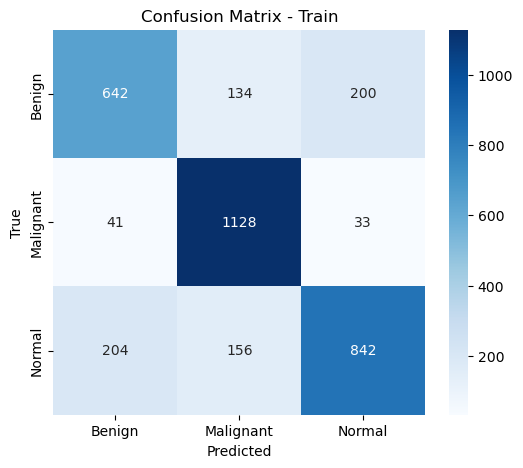

19/19 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step

 Classification Report (Validation)
              precision    recall  f1-score   support

      Benign       0.69      0.62      0.66       244
   Malignant       0.50      0.27      0.35        55
      Normal       0.70      0.82      0.75       301

    accuracy                           0.69       600
   macro avg       0.63      0.57      0.59       600
weighted avg       0.68      0.69      0.68       600



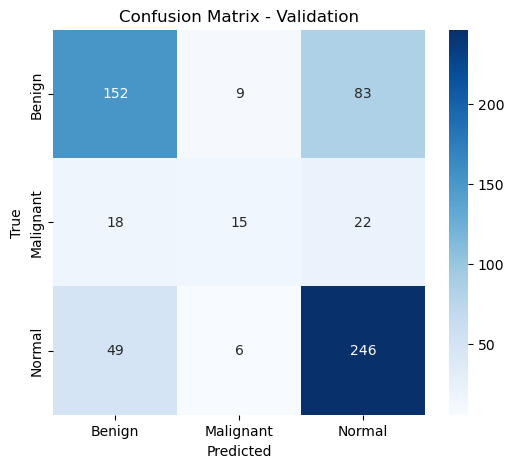

24/24 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step

 Classification Report (Test)
              precision    recall  f1-score   support

      Benign       0.68      0.61      0.64       305
   Malignant       0.39      0.25      0.30        69
      Normal       0.71      0.82      0.76       376

    accuracy                           0.68       750
   macro avg       0.59      0.56      0.57       750
weighted avg       0.67      0.68      0.67       750



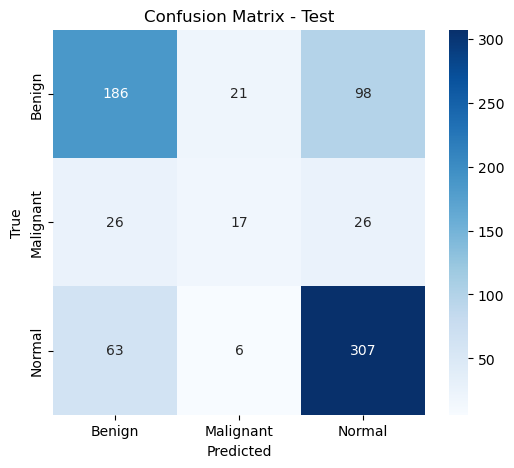

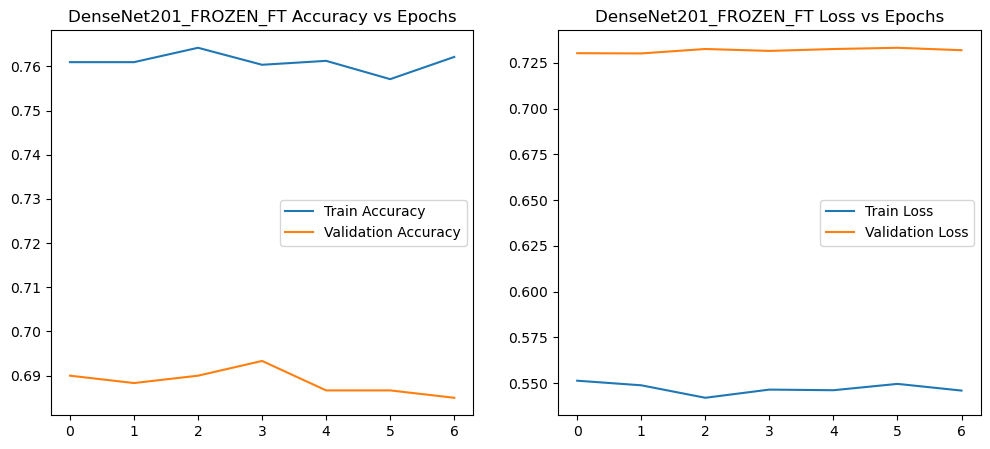


--- Inference Durations ---
Training data:   230.47 seconds
Validation data: 40.63 seconds
Test data:       45.62 seconds


In [ ]:
# Evaluation data generator for training set (shuffle=False for consistent evaluation)
train_data_eval_201 = train_gen.flow_from_dataframe(
    train_df_aug,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

# Load the best fine-tuned DenseNet201 model
densenet201_ft_model_path = os.path.join(BASE_DIR, 'densenet201_FROZEN_FT.keras')
densenet201_ft_model = load_model(densenet201_ft_model_path)


# Load DenseNet201 model training history:
history_path = os.path.join(BASE_DIR, 'history_ft_201.pkl')
with open(history_path, 'rb') as f:
    history_frozen_201_dict = pickle.load(f)

class DummyHistory:
    def __init__(self, history_dict):
        self.history = history_dict
history_ft_201 = DummyHistory(history_frozen_201_dict)

# Evaluate on Train set
train_start = time.time()
evaluate_model(densenet201_ft_model, train_data_eval_201, dataset_name="Train")
train_end = time.time()

# Evaluate on Validation set
val_start = time.time()
evaluate_model(densenet201_ft_model, val_data, dataset_name="Validation")
val_end = time.time()

# Evaluate on Test set
test_start = time.time()
evaluate_model(densenet201_ft_model, test_data, dataset_name="Test")
test_end = time.time()

# Plot training curves
plot_training_curves(history_ft_201, title_prefix="DenseNet201_FROZEN_FT")


# Print Inference Times
print("\n--- Inference Durations ---")
print(f"Training data:   {round(train_end - train_start, 2)} seconds")
print(f"Validation data: {round(val_end - val_start, 2)} seconds")
print(f"Test data:       {round(test_end - test_start, 2)} seconds")


---
### **EFFICIENTNETB4:**

**EfficientNet B4 Frozen Training:**

In [ ]:
# Load EfficientNetB4 base model
efficientnetb4_base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
efficientnetb4_base_model.trainable = False 

# Custom head
x = GlobalAveragePooling2D()(efficientnetb4_base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(len(train_data.class_indices), activation='softmax')(x)

efficientnetb4_model = Model(inputs=efficientnetb4_base_model.input, outputs=output)

# Compile the model
efficientnetb4_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
    ModelCheckpoint(
        filepath=os.path.join(BASE_DIR, 'efficientnetb4_FROZEN.keras'),
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

# Train the model
start = time.time()
history_frozen_b4 = efficientnetb4_model.fit(
    train_data,
    validation_data=val_data,
    epochs=30,
    class_weight=class_weight,
    callbacks=callbacks,
    verbose=1
)
end = time.time()

print(f"EfficientNetB4 full frozen Training Time: {round(end - start, 2)} seconds")

# Save training history
with open(os.path.join(BASE_DIR, 'history_frozen_b4.pkl'), 'wb') as f:
    pickle.dump(history_frozen_b4.history, f)


71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3496 - loss: 1.1616
Epoch 1: val_loss improved from inf to 1.36144, saving model to F:\NW_MSDS\Term-6\CV\Project\Bone_xray\BTXRD\efficientnetb4_FROZEN.keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 189s 2s/step - accuracy: 0.3496 - loss: 1.1616 - val_accuracy: 0.0917 - val_loss: 1.3614 - learning_rate: 1.0000e-04
Epoch 2/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3620 - loss: 1.1467
Epoch 2: val_loss improved from 1.36144 to 1.32108, saving model to F:\NW_MSDS\Term-6\CV\Project\Bone_xray\BTXRD\efficientnetb4_FROZEN.keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - accuracy: 0.3619 - loss: 1.1467 - val_accuracy: 0.0917 - val_loss: 1.3211 - learning_rate: 1.0000e-04
Epoch 3/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3537 - loss: 1.1437
Epoch 3: val_loss did not improve from 1.32108
106/106 ━━━━━━━━━━━━━━━━━━━━ 171s 2s/step - accuracy: 0.3537 - loss: 1.1437 -

**EfficientNet B4 Frozen Evaluation:**

106/106 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step

 Classification Report (Train)
              precision    recall  f1-score   support

      Benign       1.00      0.00      0.01       976
   Malignant       0.36      1.00      0.53      1202
      Normal       0.00      0.00      0.00      1202

    accuracy                           0.36      3380
   macro avg       0.45      0.33      0.18      3380
weighted avg       0.42      0.36      0.19      3380



e:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


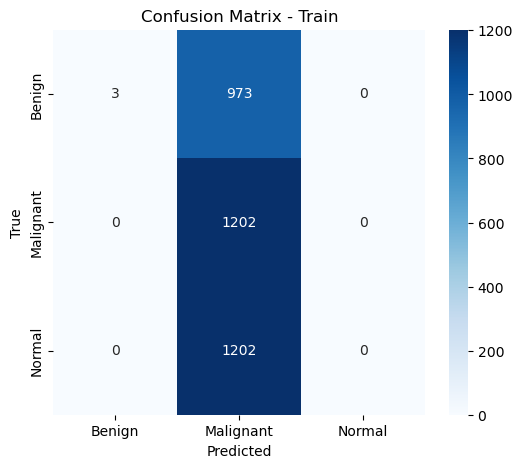

19/19 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step

 Classification Report (Validation)
              precision    recall  f1-score   support

      Benign       0.00      0.00      0.00       244
   Malignant       0.09      1.00      0.17        55
      Normal       0.00      0.00      0.00       301

    accuracy                           0.09       600
   macro avg       0.03      0.33      0.06       600
weighted avg       0.01      0.09      0.02       600



e:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


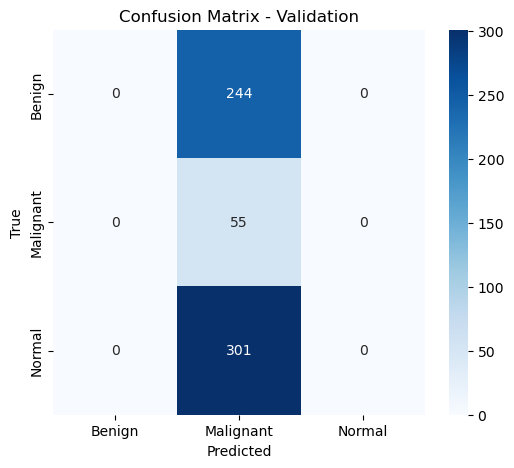

24/24 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step

 Classification Report (Test)
              precision    recall  f1-score   support

      Benign       0.00      0.00      0.00       305
   Malignant       0.09      1.00      0.17        69
      Normal       0.00      0.00      0.00       376

    accuracy                           0.09       750
   macro avg       0.03      0.33      0.06       750
weighted avg       0.01      0.09      0.02       750



e:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


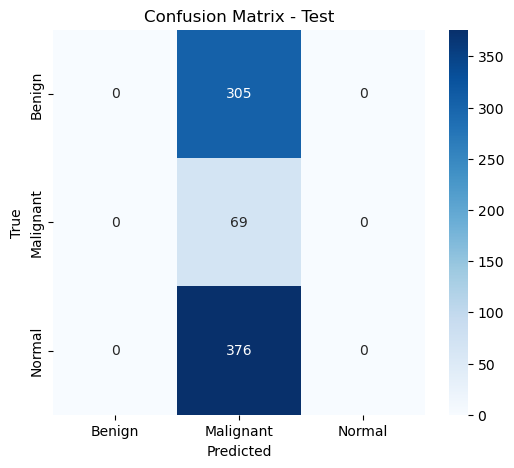

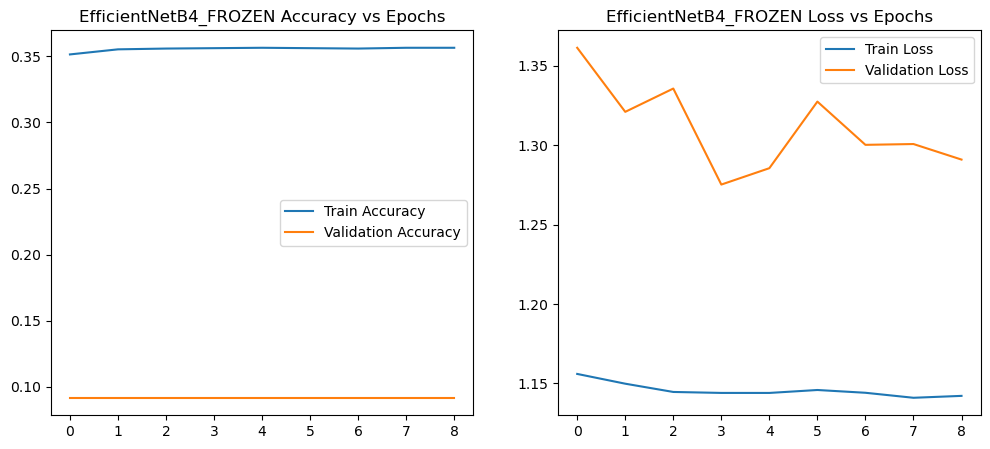


--- Inference Durations ---
Training data:   168.91 seconds
Validation data: 28.35 seconds
Test data:       32.19 seconds


In [31]:
# Load best frozen EfficientNetB4 model
efficientnetb4_frozen_best_path = os.path.join(BASE_DIR, 'efficientnetb4_FROZEN.keras')
efficientnetb4_frozen_best_model = load_model(efficientnetb4_frozen_best_path)

# Load DenseNet201 model training history:
history_path = os.path.join(BASE_DIR, 'history_frozen_b4.pkl')
with open(history_path, 'rb') as f:
    history_frozen_b4_dict = pickle.load(f)

class DummyHistory:
    def __init__(self, history_dict):
        self.history = history_dict
history_frozen_b4 = DummyHistory(history_frozen_b4_dict)


# Evaluate on Train set with timing
train_start = time.time()
evaluate_model(efficientnetb4_frozen_best_model, train_data_eval, dataset_name="Train")
train_end = time.time()

# Evaluate on Validation set with timing
val_start = time.time()
evaluate_model(efficientnetb4_frozen_best_model, val_data, dataset_name="Validation")
val_end = time.time()

# Evaluate on Test set with timing
test_start = time.time()
evaluate_model(efficientnetb4_frozen_best_model, test_data, dataset_name="Test")
test_end = time.time()

# Plot training curves for frozen model
plot_training_curves(history_frozen_b4, title_prefix="EfficientNetB4_FROZEN")

# Print Inference Times
print("\n--- Inference Durations ---")
print(f"Training data:   {round(train_end - train_start, 2)} seconds")
print(f"Validation data: {round(val_end - val_start, 2)} seconds")
print(f"Test data:       {round(test_end - test_start, 2)} seconds")


**EfficientNet B4 Finetuning:**

In [45]:
efficientnetb4_frozen_model_path = os.path.join(BASE_DIR, 'efficientnetb4_FROZEN.keras')
efficientnetb4_model = load_model(efficientnetb4_frozen_model_path)

# Fine-tune
efficientnetb4_model.trainable = True
efficientnetb4_model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

callbacks_ft = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
    ModelCheckpoint(filepath=os.path.join(BASE_DIR, 'efficientnetb4_FROZEN_FT.keras'),
                    monitor='val_loss', save_best_only=True, verbose=1)
]

start = time.time()
history_ft_b4 = efficientnetb4_model.fit(train_data,
                       validation_data=val_data,
                       epochs=30,
                       class_weight=class_weight,
                       callbacks=callbacks_ft,
                       verbose=1)
end = time.time()
print(f"EfficientNetB4 Fine-tuning Time: {round(end - start, 2)} seconds")

# Save History :
with open(os.path.join(BASE_DIR, 'history_ft_b4.pkl'), 'wb') as f:
    pickle.dump(history_ft_b4.history, f)

Epoch 1/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3584 - loss: 1.1413
Epoch 1: val_loss improved from inf to 1.29480, saving model to F:\NW_MSDS\Term-6\CV\Project\Bone_xray\BTXRD\efficientnetb4_FROZEN_FT.keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step - accuracy: 0.3584 - loss: 1.1413 - val_accuracy: 0.0917 - val_loss: 1.2948 - learning_rate: 1.0000e-05
Epoch 2/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3470 - loss: 1.1433
Epoch 2: val_loss did not improve from 1.29480
106/106 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - accuracy: 0.3471 - loss: 1.1433 - val_accuracy: 0.0917 - val_loss: 1.3050 - learning_rate: 1.0000e-05
Epoch 3/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3552 - loss: 1.1394
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 3: val_loss did not improve from 1.29480
106/106 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step - accuracy: 0.3552 - loss: 1.1394 - val_accuracy: 0.0917 - val_loss: 1.3053 - learning_rate: 1.0000e

**EfficientNet B4 FineTuned Evaluation:**

106/106 ━━━━━━━━━━━━━━━━━━━━ 178s 2s/step

 Classification Report (Train)
              precision    recall  f1-score   support

      Benign       1.00      0.00      0.00       976
   Malignant       0.36      1.00      0.52      1202
      Normal       0.00      0.00      0.00      1202

    accuracy                           0.36      3380
   macro avg       0.45      0.33      0.18      3380
weighted avg       0.42      0.36      0.19      3380



e:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


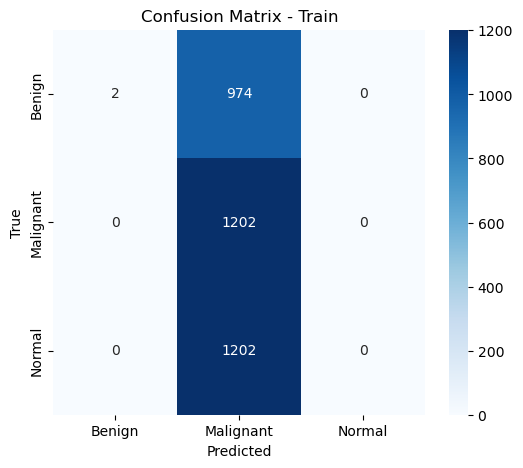

19/19 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step

 Classification Report (Validation)
              precision    recall  f1-score   support

      Benign       0.00      0.00      0.00       244
   Malignant       0.09      1.00      0.17        55
      Normal       0.00      0.00      0.00       301

    accuracy                           0.09       600
   macro avg       0.03      0.33      0.06       600
weighted avg       0.01      0.09      0.02       600



e:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


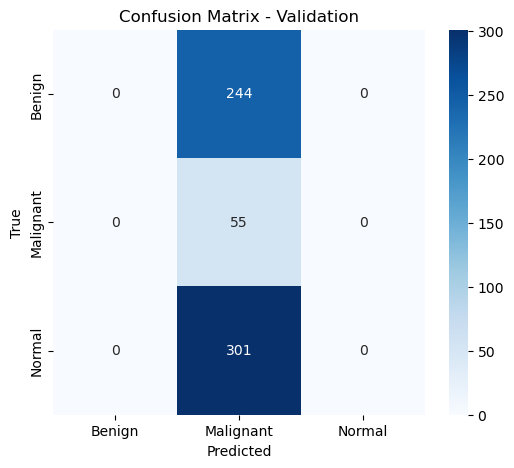

24/24 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step

 Classification Report (Test)
              precision    recall  f1-score   support

      Benign       0.00      0.00      0.00       305
   Malignant       0.09      1.00      0.17        69
      Normal       0.00      0.00      0.00       376

    accuracy                           0.09       750
   macro avg       0.03      0.33      0.06       750
weighted avg       0.01      0.09      0.02       750



e:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


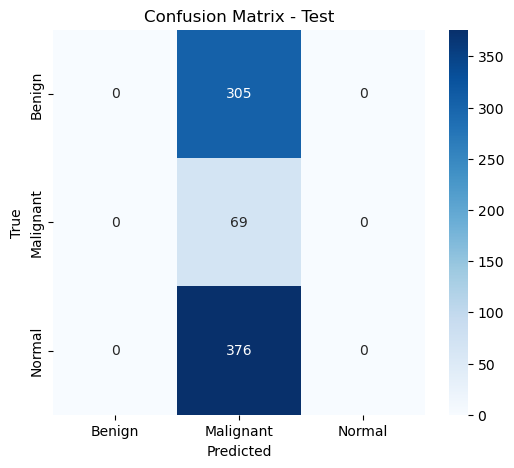

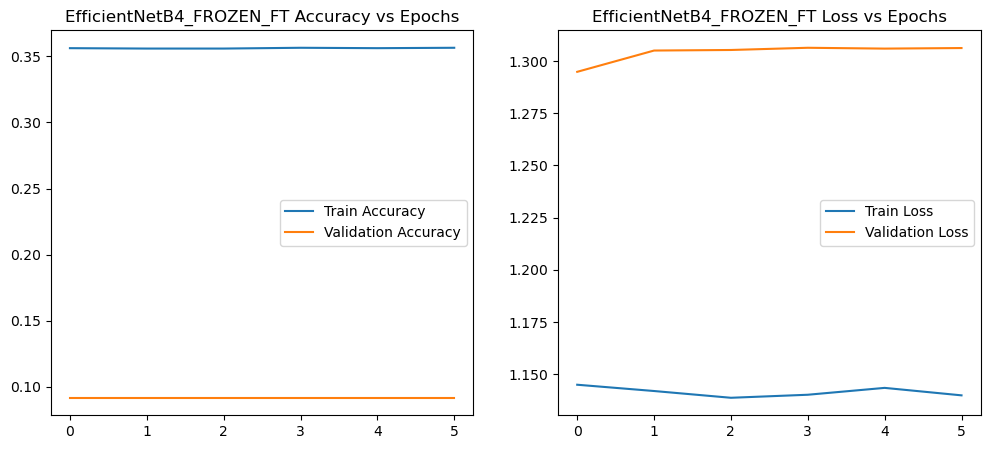


--- Inference Durations ---
Train data:      180.24 seconds
Validation data: 30.87 seconds
Test data:       37.67 seconds


In [32]:
# Reload best fine-tuned model
efficientnetb4_ft_model_path = os.path.join(BASE_DIR, 'efficientnetb4_FROZEN_FT.keras')
efficientnetb4_ft_model = load_model(efficientnetb4_ft_model_path)

# Load EfficientB4 fine tuned model training history:
history_path = os.path.join(BASE_DIR, 'history_ft_b4.pkl')
with open(history_path, 'rb') as f:
    history_ft_b4_dict = pickle.load(f)

class DummyHistory:
    def __init__(self, history_dict):
        self.history = history_dict
history_ft_b4 = DummyHistory(history_ft_b4_dict)


# Evaluate (ensure train_data_eval is prepared with shuffle=False)
train_start = time.time()
evaluate_model(efficientnetb4_ft_model, train_data_eval, dataset_name="Train")
train_end = time.time()

val_start = time.time()
evaluate_model(efficientnetb4_ft_model, val_data, dataset_name="Validation")
val_end = time.time()

test_start = time.time()
evaluate_model(efficientnetb4_ft_model, test_data, dataset_name="Test")
test_end = time.time()

# Plot training curves
plot_training_curves(history_ft_b4, title_prefix="EfficientNetB4_FROZEN_FT")

# Print inference durations
print("\n--- Inference Durations ---")
print(f"Train data:      {round(train_end - train_start, 2)} seconds")
print(f"Validation data: {round(val_end - val_start, 2)} seconds")
print(f"Test data:       {round(test_end - test_start, 2)} seconds")
